In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch 
from torch import nn


import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

### Getting the dataset

The dataset used is Fashion MNIST from torchvision datasets.

In [3]:
# Setup the training data

train_data = datasets.FashionMNIST(
    root="data", # Where to download data to
    train=True, 
    download=True,
    transform=ToTensor(), # Convert to tensors
    target_transform=None
)

# Setup the test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 25.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 2.86MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 19.3MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.1MB/s]


In [4]:
image, label = train_data[0]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: 9


In [5]:
class_names = train_data.classes
class_names
print(f"Class names: {class_names}")
print(f"Class the image belongs to: {class_names[label]}")

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class the image belongs to: Ankle boot


In [7]:
# Get a dictionary of class names and their corresponding indices

class_to_idx = train_data.class_to_idx
class_to_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### Visualising the data

Displaying the image and as expected, it is an image of an ankle boot.

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]


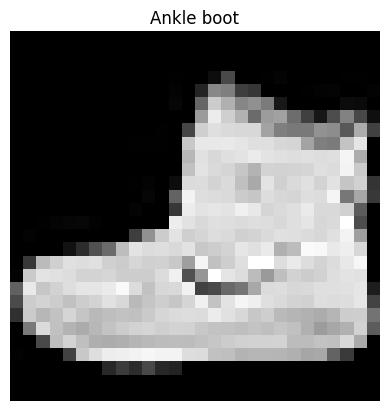

In [13]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

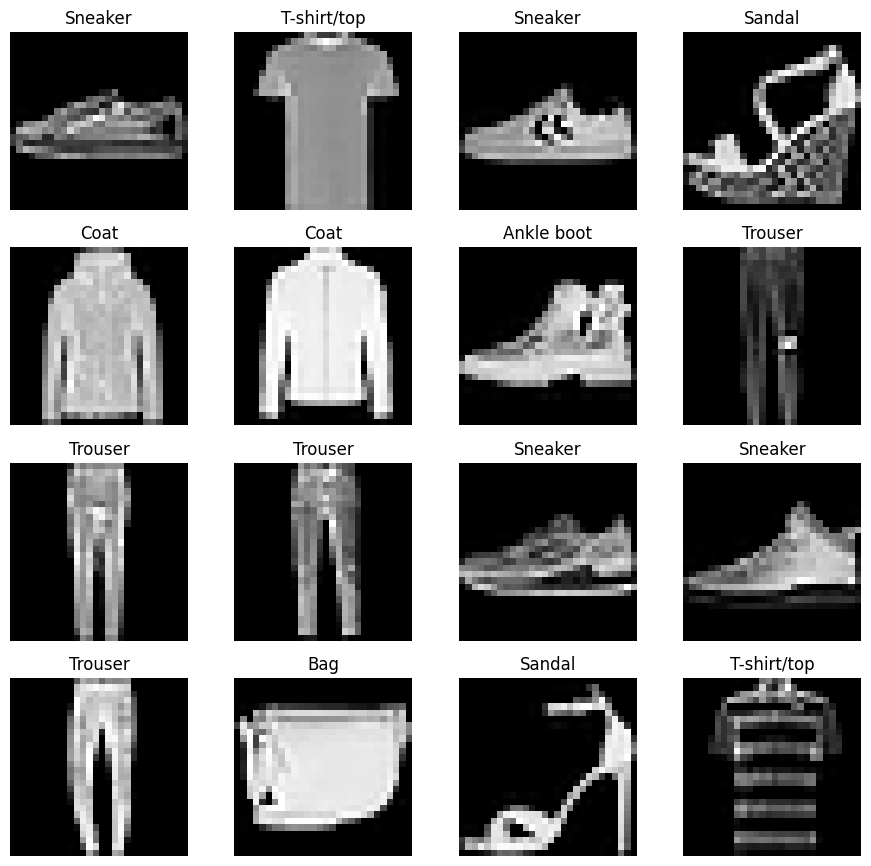

In [16]:
# Displaying more images
# torch.manual_seed(101)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    fig.tight_layout()
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
plt.show()

In [17]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Prepare DataLoader 

Right now, the data is in the form of PyTorch datasets.

DataLoader turns the dataset into Python iterables.
More specifically, turn the data into batches (or mini batches).

- To make it more computationally efficient.
- Break it down to 32 images at a time (batch_size=32)
- Gives more chances to neural networks to update its gradients per epoch.

In [6]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True # Shuffle the data to remove any order
)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc9938ddfd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc993a44e10>)

In [ ]:
# Checking out how many batches we have in the training and test dataloaders

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x116225d30>, <torch.utils.data.dataloader.DataLoader object at 0x1194707d0>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [20]:
# What is inside the training dataloader?
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label: Shirt


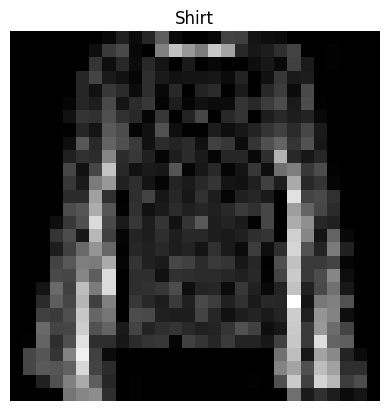

In [18]:
# Show a sample
torch.manual_seed(101)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Label: {class_names[label]}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

### Model 0: Baseline Model

Simple model -> Will try and improve upon with subsequent models/experiments.

In other words, start simply and add complexity if necessary

In [21]:
from torch import nn

# Model Architecture
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

Creating device agnostic code.

In [22]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [23]:
torch.manual_seed(101)

# Create an instance of the model
model_0 = FashionMNISTModelV0(
    input_shape=28 * 28, # 28*28 = 784
    hidden_units=10, 
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy_x)

tensor([[-0.1723,  0.1965, -0.0517, -0.1656, -0.2674,  0.1031,  0.0634, -0.0318,
          0.1768, -0.4256]], device='mps:0', grad_fn=<LinearBackward0>)

In [26]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[-0.0216, -0.0036, -0.0292,  ..., -0.0166, -0.0342, -0.0019],
                      [ 0.0088,  0.0261,  0.0046,  ...,  0.0073,  0.0056, -0.0018],
                      [-0.0336, -0.0348, -0.0216,  ..., -0.0165,  0.0112,  0.0169],
                      ...,
                      [ 0.0022,  0.0105,  0.0171,  ..., -0.0252, -0.0354, -0.0325],
                      [-0.0040, -0.0022, -0.0179,  ...,  0.0089, -0.0104, -0.0307],
                      [ 0.0171,  0.0039,  0.0017,  ..., -0.0158,  0.0015,  0.0329]],
                     device='mps:0')),
             ('layer_stack.1.bias',
              tensor([-0.0329,  0.0271,  0.0073, -0.0253,  0.0012, -0.0280, -0.0194,  0.0183,
                       0.0124,  0.0090], device='mps:0')),
             ('layer_stack.2.weight',
              tensor([[ 3.3825e-02,  2.9985e-01,  2.8862e-01,  9.9982e-02,  2.0723e-01,
                       -2.5640e-01, -3.1564e-01,  1.5375e-01, -8.9732e-02,  

### Setup loss, optimizer and evaluation metrics

* Loss function - since we are working with multi class data, our loss function should be `nn.CrossEntropyLoss()`

* Optimiser - our optimizer `torch.optim.SGD()` Stochastic Gradient Descent.

* Evaluation Metric - Since we are working on classification problem, let's use accuracy as an evaluation metric. 
 

In [27]:
LEARNING_RATE = 0.1 # Tweaked each epoch

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

### Time the experiements

In [28]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    return total_time

### Creating a training loop and training the model on batches of data

- Loop through epochs.
- Loop through training batches, perform training steps, calculating the train loss *per batch*
- Loop through testing batches, perform testing steps, calculate the test loss *per batch*
- Print out what is happening.
- Time it all 

In [33]:
from tqdm.auto import tqdm

# Set seed and start timer
torch.manual_seed(101)
train_time = timer()

# Set the number of epochs
NUM_EPOCHS = 5

# Creating a training loop and training the model on batches of data
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    ### Training
    train_loss = 0
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        # Move data to device
        X, y = X.to(device), y.to(device)
        
        model_0.train()

        # Forward pass
        y_pred = model_0(X)

        # Calculate loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # Accumulate train loss

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimiser step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss = 0
    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Move data to device
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # Make predictions
            test_pred = model_0(X_test)

            # Calculate loss per batch
            test_loss += loss_fn(test_pred, y_test).item()
            
    # Divide total test loss by length of test dataloader
    test_loss /= len(test_dataloader)

    # Print out what's happening
    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

# Calculate the training time
train_time_end = timer()
print_train_time(start=train_time, end=train_time_end)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 20%|██        | 1/5 [00:05<00:20,  5.24s/it]

Train loss: 0.4741 | Test loss: 0.4835
Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 40%|████      | 2/5 [00:10<00:15,  5.31s/it]

Train loss: 0.4529 | Test loss: 0.4869
Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 60%|██████    | 3/5 [00:15<00:10,  5.35s/it]

Train loss: 0.4429 | Test loss: 0.5125
Epoch: 3
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 80%|████████  | 4/5 [00:21<00:05,  5.36s/it]

Train loss: 0.4334 | Test loss: 0.4759
Epoch: 4
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

Train loss: 0.4305 | Test loss: 0.4566
Train time on device mps: 26.693 seconds


26.692968082992593

### Make predictions and get Model 0 inference